In [44]:
import pandas as pd
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split_variables.h5','r') as store:
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')


X = X_test.values
Y = Y_test.values

(264, 20)

In [45]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import numpy as np


window_size = 60
latent_variables = 3
n_pred_obs = 3

N_seg = X.shape[0]-window_size-n_pred_obs

model = make_pipeline(StandardScaler(), PLSRegression(n_components=latent_variables))

Y_test_pred = np.zeros((Y.shape[0],n_pred_obs))
outlier_mask = np.zeros_like(Y, np.bool_)
for seg in range(N_seg):

    # Find indeces matching the segment
    X_seg_cal = X[ seg:seg+window_size, : ] 
    X_seg_test = X[ seg+window_size:seg+window_size+n_pred_obs, : ]
    Y_seg_cal = Y[ seg:seg+window_size ]
    Y_seg_test = Y[ seg+window_size:seg+window_size+n_pred_obs ]    

    model.fit(X_seg_cal, Y_seg_cal)

    Y_test_pred_seg = model.predict(X_seg_test)


    # Replace outliers with previous predicted value
    outlier_mask =  (Y_test_pred_seg < 0) | (Y_test_pred_seg > 6) | (abs(Y_test_pred_seg - Y_seg_cal[-1])>2.5)
    Y_test_pred_seg[outlier_mask] = Y_seg_cal[-1]

    Y_test_pred[seg+window_size,0] = Y_test_pred_seg[0]
    Y_test_pred[seg+window_size+1,1] = Y_test_pred_seg[1]
    Y_test_pred[seg+window_size+2,2] = Y_test_pred_seg[2]

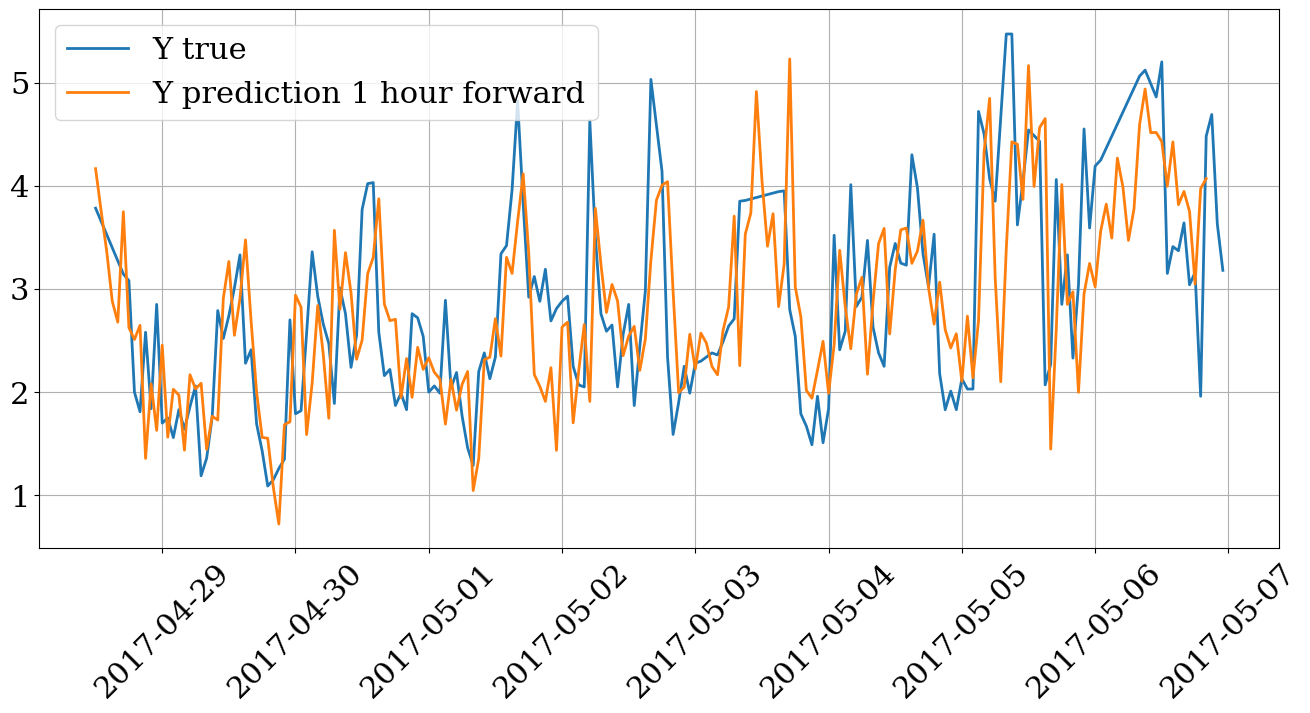

In [69]:
from matplotlib import pyplot as plt

plt.rcParams.update({
    "font.family": "serif ",
    "font.size":22
})

plt.figure(figsize=(16,7))
plt.plot(Y_test[window_size:],linewidth=2,label='Y true')
plt.plot(Y_test.index[window_size:-3],Y_test_pred[window_size:-3,0],linewidth=2,label='Y prediction 1 hour forward')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc=2)

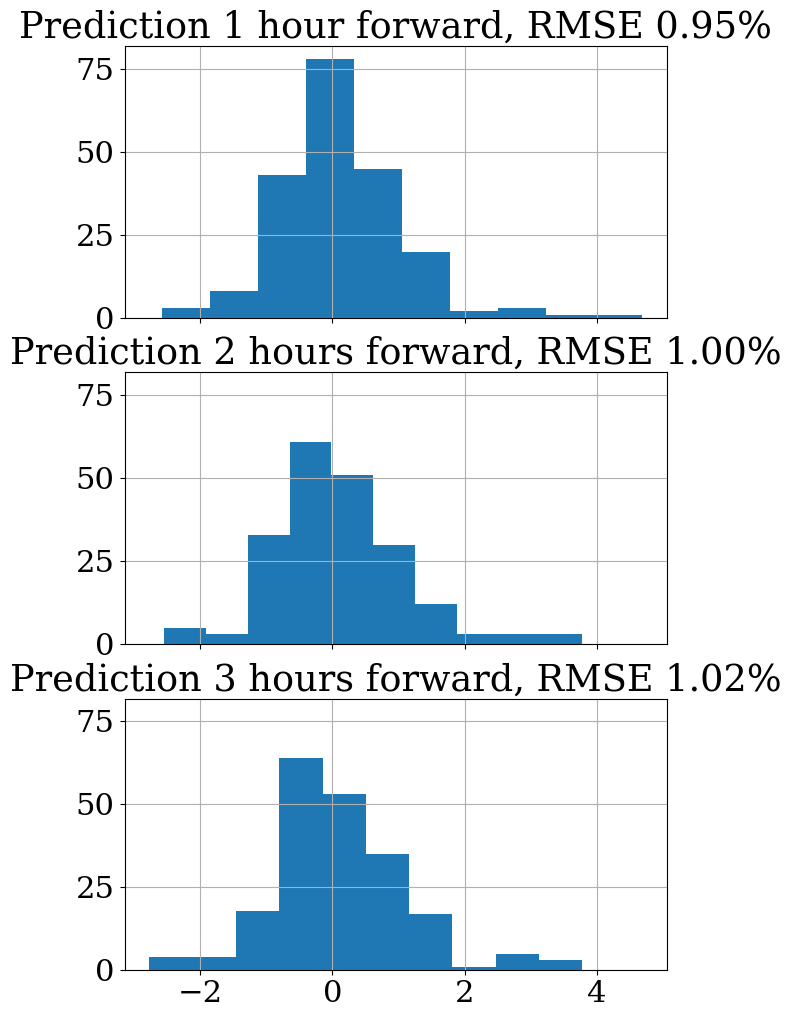

In [71]:

fig,axes = plt.subplots(3,1,sharex=True,sharey=True,figsize=(7,12))

axes[0].hist((Y[window_size:]-Y_test_pred[window_size:,0]))
rmse = np.sqrt(np.mean((Y[window_size:]-Y_test_pred[window_size:,0])**2))
axes[0].set_title(f'Prediction 1 hour forward, RMSE {rmse:.2f}%')
axes[1].hist((Y[window_size:]-Y_test_pred[window_size:,1]))
rmse = np.sqrt(np.mean((Y[window_size:]-Y_test_pred[window_size:,1])**2))
axes[1].set_title(f'Prediction 2 hours forward, RMSE {rmse:.2f}%')
axes[2].hist((Y[window_size:]-Y_test_pred[window_size:,2]))
rmse = np.sqrt(np.mean((Y[window_size:]-Y_test_pred[window_size:,2])**2))
axes[2].set_title(f'Prediction 3 hours forward, RMSE {rmse:.2f}%')

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)

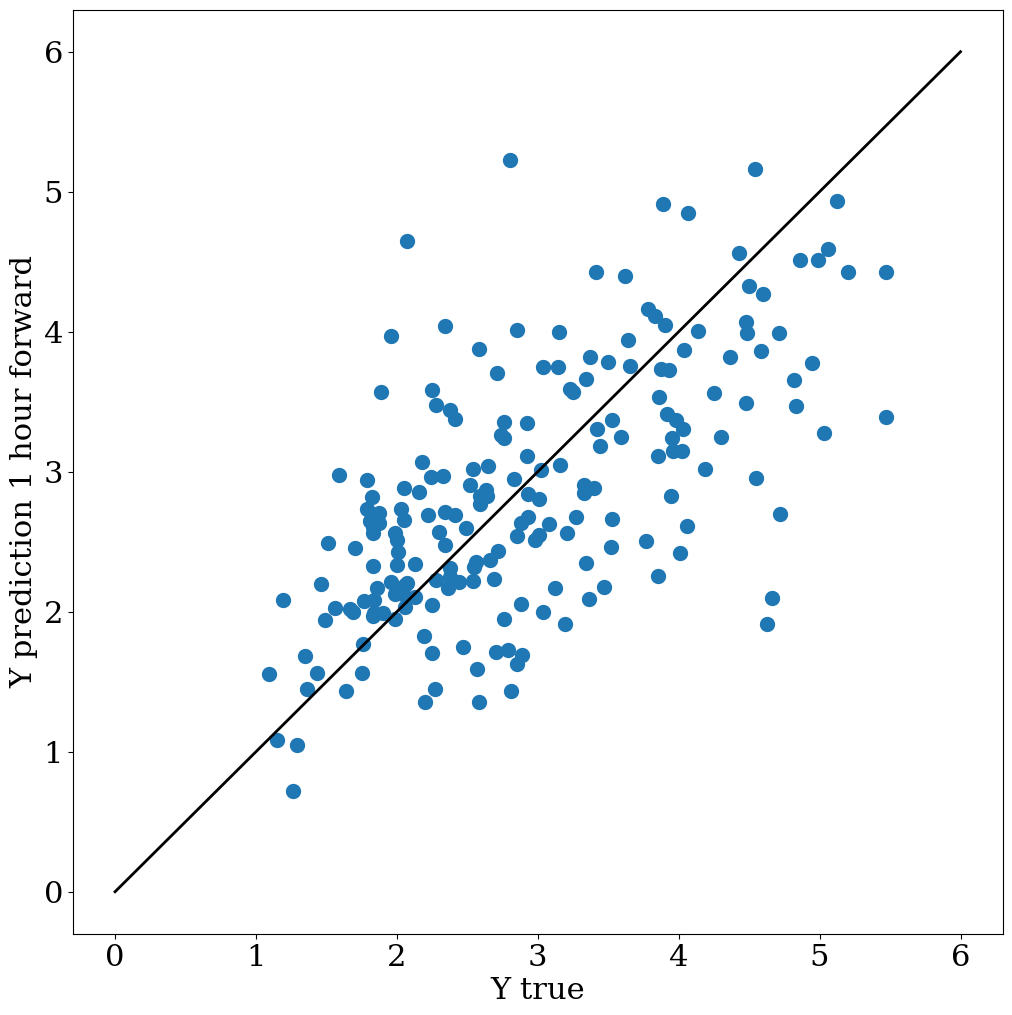

In [78]:
plt.figure(figsize=(12,12))
plt.scatter(Y[window_size:-3],Y_test_pred[window_size:-3,0],linewidths=5)
plt.xlabel('Y true')
plt.ylabel('Y prediction 1 hour forward')
plt.plot((0,6),(0,6),'k',linewidth=2)